In [16]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from dowhy import CausalModel
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Load and Preprocess Dataset


In [17]:
# File path
file_path = '676e54b2807db_usecase_2_test_gt_removed.csv'
data = pd.read_csv(file_path)

In [18]:
# Display initial shape of the dataset
print("Initial dataset shape:", data.shape)

Initial dataset shape: (17286, 2050)


In [19]:
# Check for null values and their percentages
null_counts = data.isnull().sum()
null_percentage = (null_counts / len(data)) * 100

In [20]:
# Drop columns with more than 30% null values
columns_to_drop = null_percentage[null_percentage > 30].index.tolist()
data_cleaned = data.drop(columns=columns_to_drop)

In [21]:
# Drop rows with remaining null values
data_cleaned.dropna(inplace=True)

Feature Engineering


In [22]:
# Select relevant features for prediction
selected_features = [
    'Conditions', 'Phases', 'Enrollment', 'Study Design',
    'Locations', 'Study Type', 'Interventions'
]

In [23]:
# Ensure selected features exist in the cleaned dataset
selected_features = [
    col for col in selected_features if col in data_cleaned.columns]
print("\nSelected features available for modeling:", selected_features)


Selected features available for modeling: ['Conditions', 'Enrollment', 'Study Design', 'Locations', 'Study Type', 'Interventions']


In [24]:
# Inspect and process the Enrollment column
if 'Enrollment' in data_cleaned.columns:
    data_cleaned['Enrollment'] = pd.to_numeric(
        data_cleaned['Enrollment'], errors='coerce')
    data_cleaned.dropna(subset=['Enrollment'], inplace=True)
else:
    print("\n'Enrollment' column not found. Exiting...")
    exit()

In [25]:
# Define input features (X) and target variable (y)
X = pd.get_dummies(data_cleaned[selected_features], drop_first=True)
y = data_cleaned['Enrollment']

Train-Test Split


In [26]:
# Check if data is not empty
if not X.empty and y is not None and not y.empty:
    # Set a flag to indicate that the condition is met
    modeling_ready = True

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    modeling_ready = False
    print("\nInsufficient data for modeling. Please check your preprocessing steps.")

Model Training


In [32]:
if modeling_ready:
    # Train a Random Forest Regressor model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

Evaluation Metrics


In [33]:
if modeling_ready:
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Calculate adjusted R-squared
    n = X_test.shape[0]  # Number of samples
    p = X_test.shape[1]  # Number of predictors
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    # Calculate SMAPE
    def smape(y_true, y_pred):
        numerator = np.abs(y_true - y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        smape_value = np.mean(numerator / denominator) * 100
        return smape_value

    smape_value = smape(y_test, y_pred)

    # Print all metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"Adjusted R-squared: {adjusted_r2:.2f}")
    print(f"SMAPE: {smape_value:.2f}%")

RMSE: 12557.88
R-squared: 0.47
Adjusted R-squared: 1.05
SMAPE: 0.13%


Visualizations


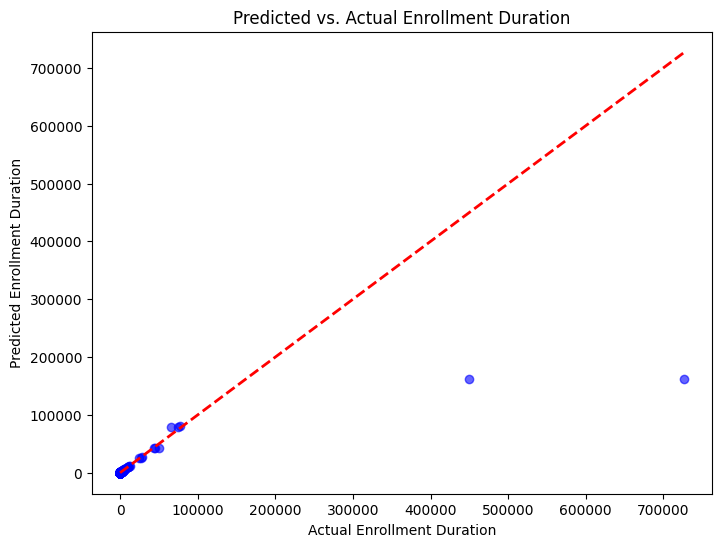

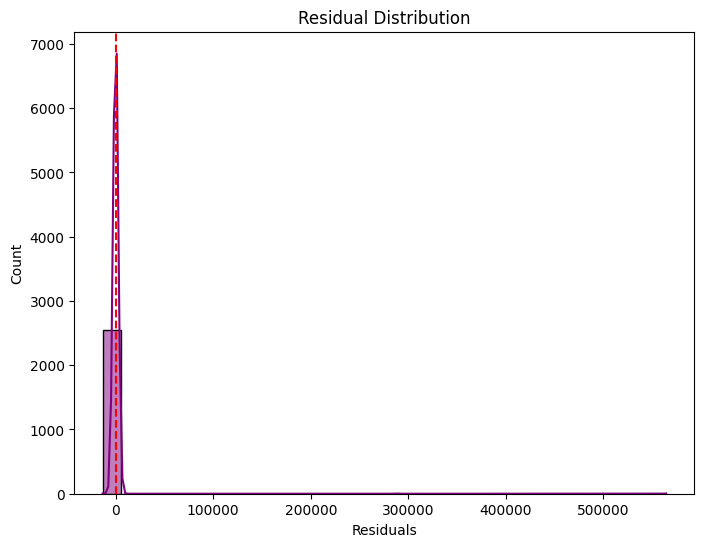

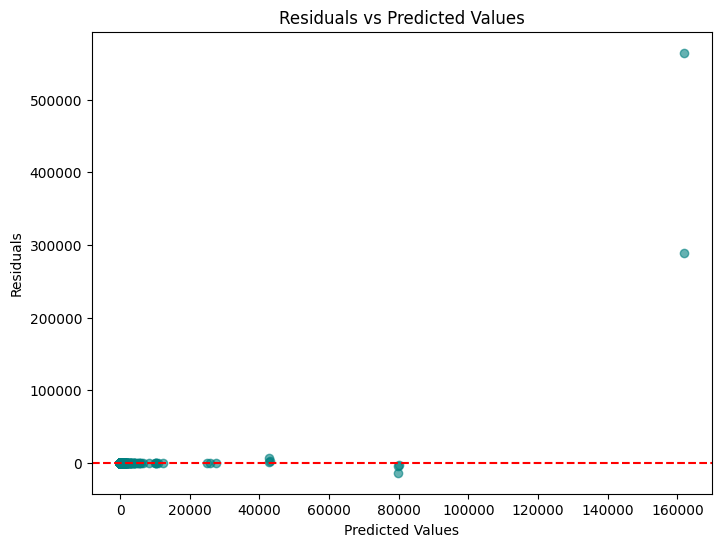

In [28]:
if modeling_ready:
    # Predicted vs. Actual Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='b')
    plt.plot([y_test.min(), y_test.max()], [
             y_test.min(), y_test.max()], 'k--', lw=2, color='r')
    plt.xlabel("Actual Enrollment Duration")
    plt.ylabel("Predicted Enrollment Duration")
    plt.title("Predicted vs. Actual Enrollment Duration")
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color='purple')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Residuals")
    plt.title("Residual Distribution")
    plt.show()

    # Scatter plot for residuals
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color='teal')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values")
    plt.show()

SHAP Explainability


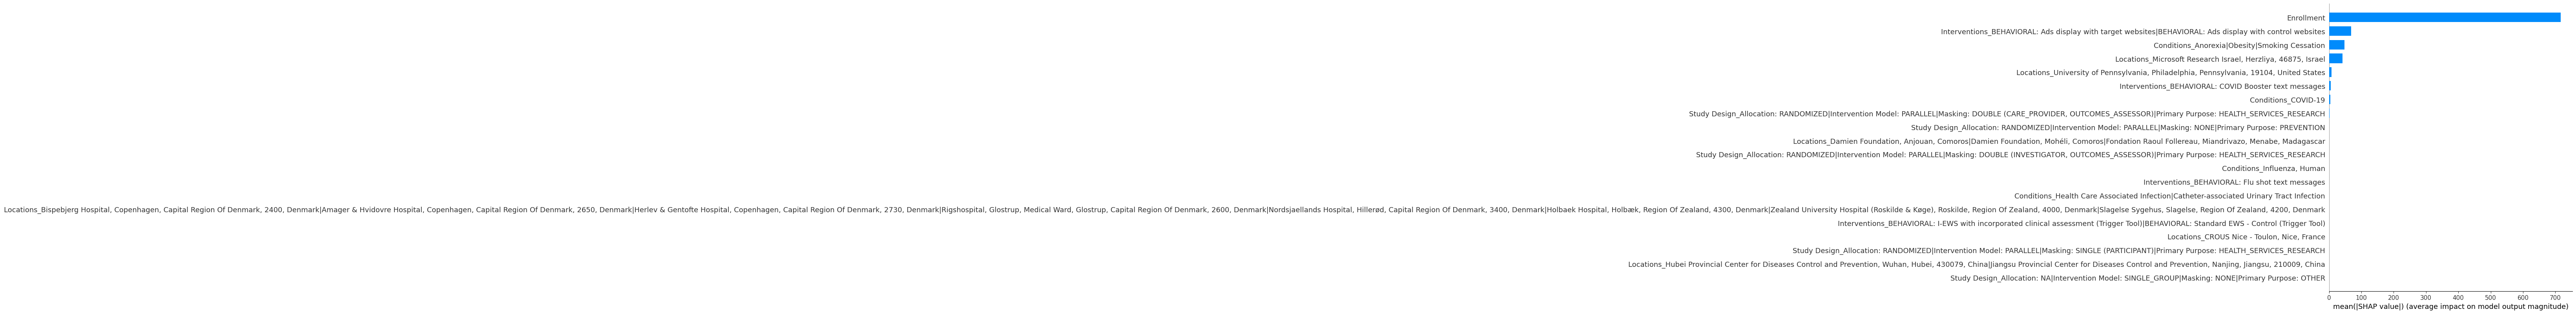

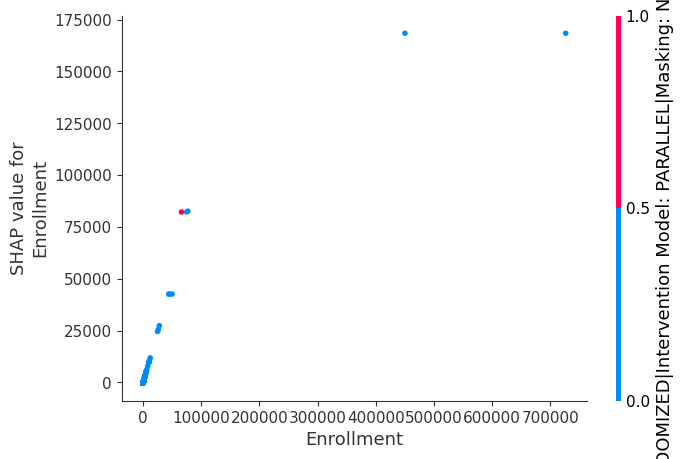

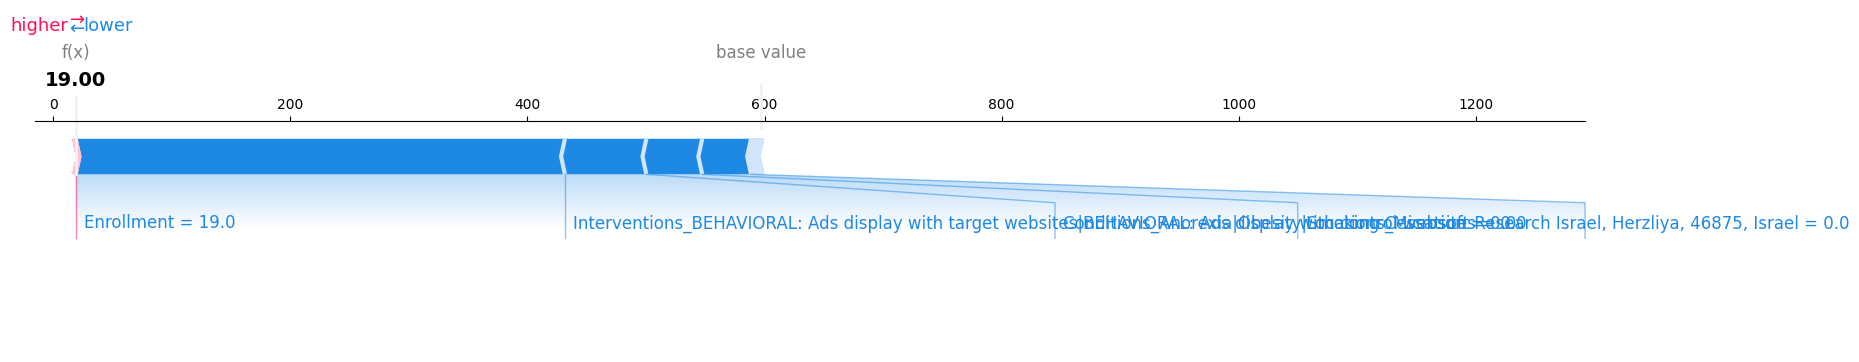

In [29]:
if modeling_ready:
    # SHAP Explainability
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    # SHAP Dependence Plot for a Specific Feature
    # Change to any feature you want to explain
    feature_to_explain = X_test.columns[0]
    shap.dependence_plot(feature_to_explain, shap_values, X_test)

    # SHAP Force Plot for a Single Prediction
    example_index = 0  # Change to any index to visualize
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[example_index],
        X_test.iloc[example_index],
        matplotlib=True,
    )

Causal Inference


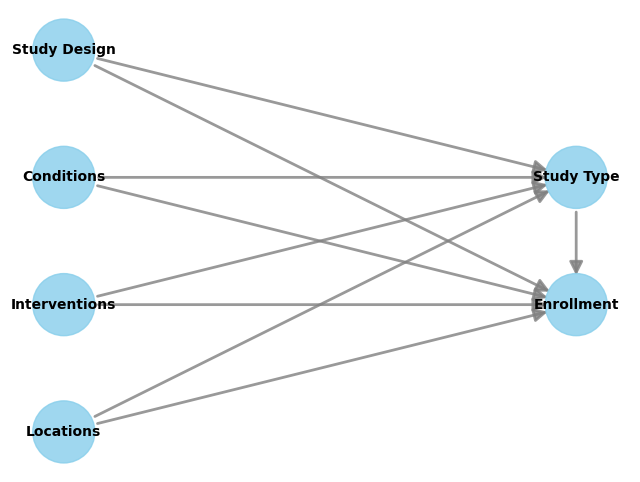

In [36]:
if modeling_ready:
    # Causal Inference with DoWhy
    causal_data = data_cleaned.copy()
    causal_data['Enrollment'] = pd.to_numeric(
        causal_data['Enrollment'], errors='coerce')

    # Modify the treatment variable based on available columns
    model_causal = CausalModel(
        data=causal_data,
        # Specify treatment variable (use Study Type or another available feature)
        treatment='Study Type',
        outcome='Enrollment',  # Outcome variable
        common_causes=['Study Design', 'Conditions',
                       'Interventions', 'Locations'],  # Adjust if necessary
    )

    # View the graph
    model_causal.view_model()
    plt.show()

Example Prediction



Example Prediction for instance 0:
Predicted Enrollment Duration: 19.00 months


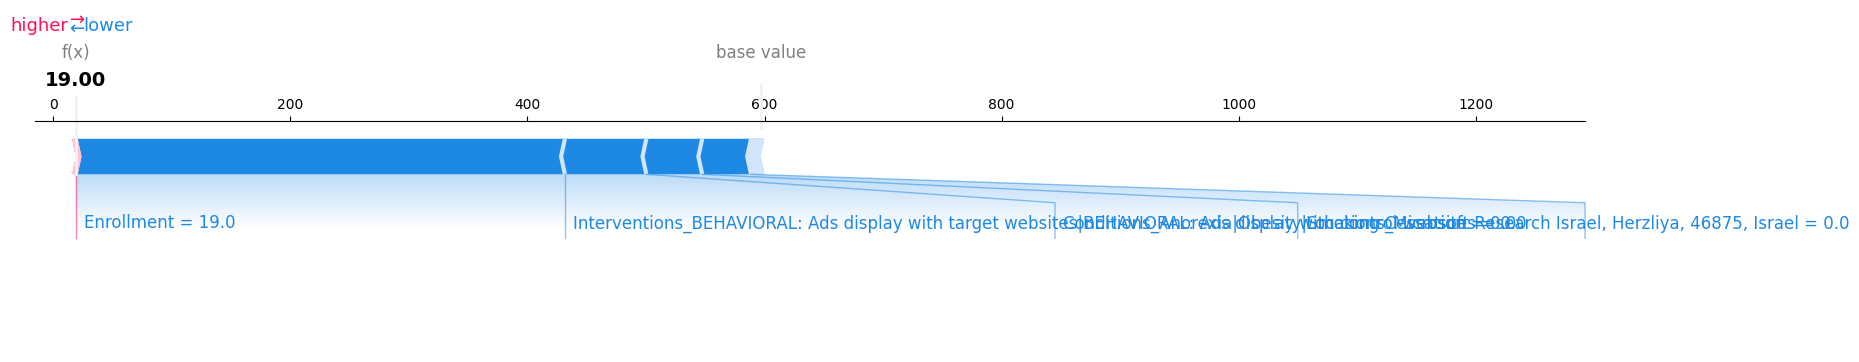


Feature Impact (Ranked by Contribution to Prediction):
Enrollment: -412.59 (Negative impact)
Interventions_BEHAVIORAL: Ads display with target websites|BEHAVIORAL: Ads display with control websites: -68.69 (Negative impact)
Conditions_Anorexia|Obesity|Smoking Cessation: -47.10 (Negative impact)
Locations_Microsoft Research Israel, Herzliya, 46875, Israel: -41.22 (Negative impact)
Interventions_BEHAVIORAL: COVID Booster text messages: -3.09 (Negative impact)
Locations_University of Pennsylvania, Philadelphia, Pennsylvania, 19104, United States: -2.96 (Negative impact)
Conditions_COVID-19: -1.53 (Negative impact)
Study Design_Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (CARE_PROVIDER, OUTCOMES_ASSESSOR)|Primary Purpose: HEALTH_SERVICES_RESEARCH: -0.63 (Negative impact)
Study Design_Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: PREVENTION: -0.32 (Negative impact)
Locations_Damien Foundation, Anjouan, Comoros|Damien Foundation, 

In [35]:
if modeling_ready and not X_test.empty:
    # Select an example index to make a prediction
    example_index = 0  # Change this to test other instances
    example_data = X_test.iloc[example_index]

    # Make the prediction
    example_prediction = model.predict([example_data])[0]

    # Print the predicted value
    print(
        f"\nExample Prediction for instance {example_index}:\nPredicted Enrollment Duration: {example_prediction:.2f} months"
    )

    # ==========================
    # SHAP Explanation for the Example Prediction
    # ==========================
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(example_data)

    # SHAP Force Plot for a Single Prediction
    shap.initjs()  # Initialize SHAP's JavaScript visualization
    shap.force_plot(
        explainer.expected_value,  # Expected value for regression
        shap_values,  # SHAP values for the regression model
        example_data,  # Input features for the example instance
        matplotlib=True,  # Use Matplotlib for static visualization
    )

    # Explanation output for each feature impact
    feature_impact = list(zip(X_test.columns, shap_values))
    feature_impact = sorted(feature_impact, key=lambda x: abs(
        x[1]), reverse=True)  # Sort by impact

    # Print feature impact
    print("\nFeature Impact (Ranked by Contribution to Prediction):")
    for feature, impact in feature_impact:
        impact_str = f"Positive impact" if impact > 0 else f"Negative impact"
        print(f"{feature}: {impact:.2f} ({impact_str})")